In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy as sp
import networkx as nx

from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from collections import defaultdict
from scipy.spatial import distance

import random


import mx_env as mxe
import mx_agents as mxa

#%matplotlib inline
#%load_ext line_profiler

from matplotlib import rc
plt.rcParams['font.size'] = '13'
plt.rcParams.update({'font.family':'sans-serif'})

# simulation function

In [24]:
def run_sim(env, agent, n_episodes, n_steps, grid_size):
    
    cs = (0,0)
    ns = (0,0)
    action = 0
    
    state_visits = np.zeros((grid_size, grid_size))
    episodic_error = []
    experiences = []
    
    cs_st = 0
    td_v = 0

    for ep in range(n_episodes):
        cs = (0,0)
        for k in range(n_steps):
            
            # initial action and next state reward sampling
            action = agent.sample_action(cs_st)
            ns, reward, t_flag = env.get_next_state(cs, action)
            state_visits[cs[0],cs[1]] += 1

            # mapping graph id to state
            ns_st = env.node2state(ns)
            cs_st = env.node2state(cs)
            
            # sampling next action
            next_action = agent.sample_action(ns_st)

            # updating value functions
            if (k > 1) and t_flag == False:
                experiences.append(np.asarray([cs_st, action, ns_st, next_action, reward, t_flag, ep]))
                td_v = agent.update_td(experiences[-1])

            if t_flag == True:
                experiences.append(np.asarray([cs_st, action, ns_st, next_action, reward, t_flag, ep]))
                td_v = agent.update_td(experiences[-1])
                episodic_error.append(np.mean(np.abs(td_v)))
                break

            cs = ns
        
    return np.asarray(experiences), episodic_error, state_visits

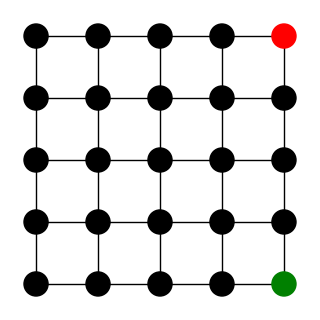

In [25]:
grid_size = 5
env = mxe.GraphEnvGenerator(grid_size)
env.generate_open_gridworld()
env.pun = [(0,4), 0]
env.rwd = [(4,4), 10]
env.paint_nodes([3,3])

# SARSA // Q-Learning

In [26]:
n_episodes = 5000
n_steps = 70

In [27]:
node_list = list(env.G.nodes)
mSize = len(node_list)
n_actions = 4
gamma = 0.7
alpha = 0.01
beta = 0.7

sar = mxa.SARSA_agent(mSize, n_actions, alpha, gamma, beta)
xp, err, sv = run_sim(env, sar, n_episodes, n_steps, grid_size)

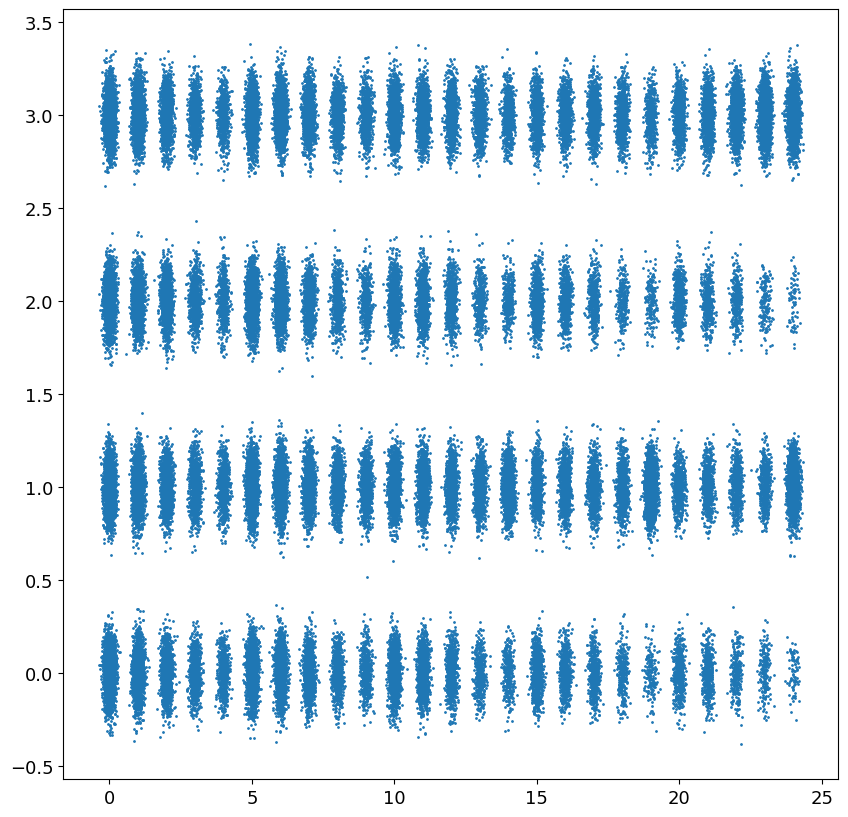

In [45]:
# select the first 2 indices of xp matrix
sa_pair = xp[:,0:2]

# add random gaussian noise to each entry of sa_pair
sa_pair = sa_pair + np.random.normal(0, 0.1, sa_pair.shape)

# plot the 2D scatter plot of sa_pair
plt.figure(figsize=(10,10))
plt.scatter(sa_pair[:,0], sa_pair[:,1], s=1)
plt.show()

In [ ]:
# learn a normalizing flow model from the sa_pair

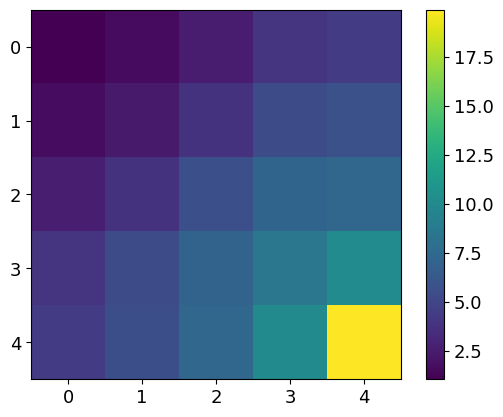

In [6]:
plt.imshow(sar.get_V(grid_size))
plt.colorbar()

In [7]:
np.max(sar.get_V())

TypeError: get_V() missing 1 required positional argument: 'grid_size'

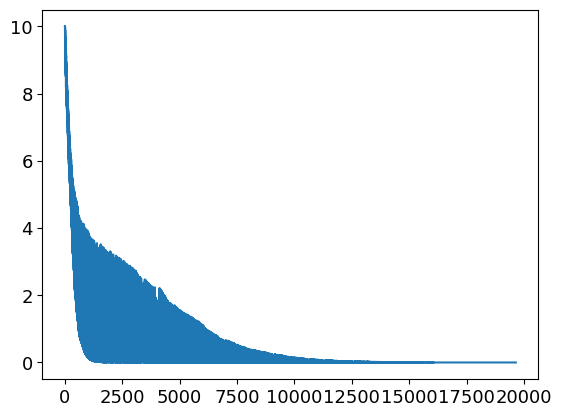

In [ ]:
plt.plot(err)

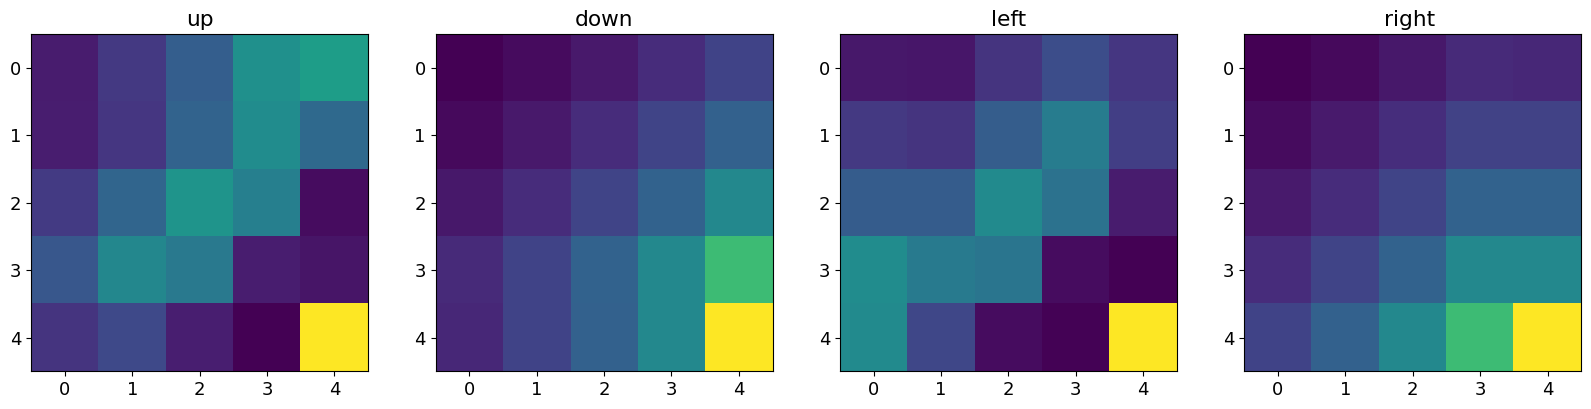

In [8]:
divider = []
cax = []
im = []
fig, ax = plt.subplots(1,4, figsize=(20,20))
ax[0].set_title('up')
ax[1].set_title('down')
ax[2].set_title('left')
ax[3].set_title('right ')
for i in range(4):
    im = ax[i].imshow(np.reshape(sar.Q[:,i], [grid_size, grid_size]))
plt.show()

# MAC

In [15]:
node_list = list(env.G.nodes)
mSize = len(node_list)
n_actions = 4
gamma = 0.6
alpha = [0.05, 0.01]
beta = 5
wA = [1, -1]

mac = MultiActorCritic(mSize, n_actions, alpha, gamma, beta, wA)
xp, err, sv = run_sim(env, mac, n_episodes, n_steps)

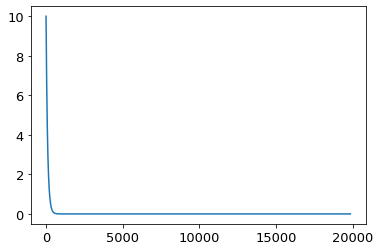

In [16]:
plt.plot(err)

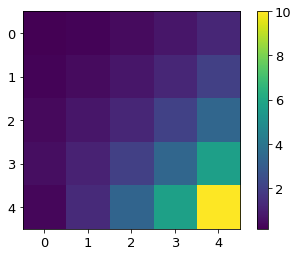

In [17]:
plt.imshow(mac.get_V())
plt.colorbar()

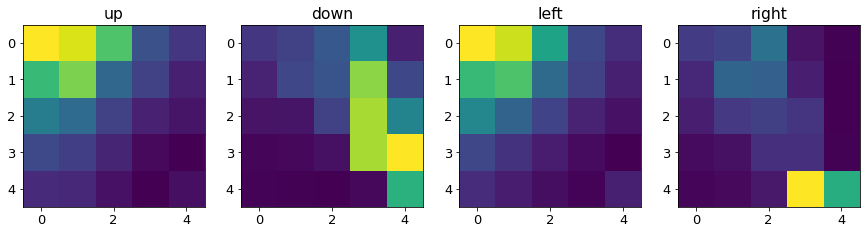

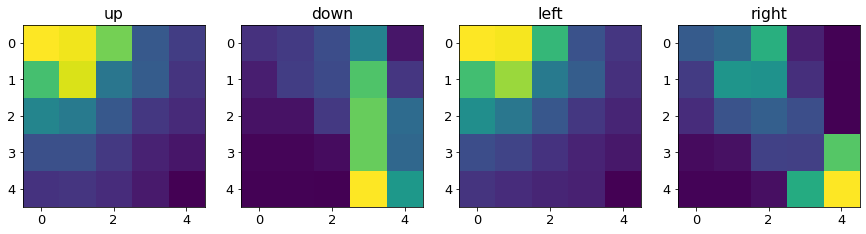

In [18]:
fig, ax = plt.subplots(1,4, figsize=(15,15))

ax[0].imshow(np.reshape(mac.A[0,:,0], [grid_size, grid_size]))
ax[0].set_title('up')
ax[1].imshow(np.reshape(mac.A[0,:,1], [grid_size, grid_size]))
ax[1].set_title('down')
ax[2].imshow(np.reshape(mac.A[0,:,2], [grid_size, grid_size]))
ax[2].set_title('left')
ax[3].imshow(np.reshape(mac.A[0,:,3], [grid_size, grid_size]))
ax[3].set_title('right')
plt.show()

fig, ax = plt.subplots(1,4, figsize=(15,15))
ax[0].imshow(np.reshape(mac.A[1,:,0], [grid_size, grid_size]))
ax[0].set_title('up')
ax[1].imshow(np.reshape(mac.A[1,:,1], [grid_size, grid_size]))
ax[1].set_title('down')
ax[2].imshow(np.reshape(mac.A[1,:,2], [grid_size, grid_size]))
ax[2].set_title('left')
ax[3].imshow(np.reshape(mac.A[1,:,3], [grid_size, grid_size]))
ax[3].set_title('right')
plt.show()

# SAC

In [19]:
node_list = list(env.G.nodes)
mSize = len(node_list)
n_actions = 4
gamma = 0.6
alpha = [0.01, 0.01]
beta = 5

sac = SingleActorCritic(mSize, n_actions, alpha, gamma, beta)
xp, err, sv = run_sim(env, sac, n_episodes, n_steps)

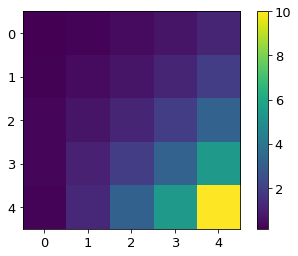

In [20]:
plt.imshow(sac.get_V())
plt.colorbar()

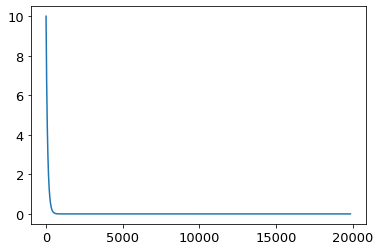

In [21]:
plt.plot(err)

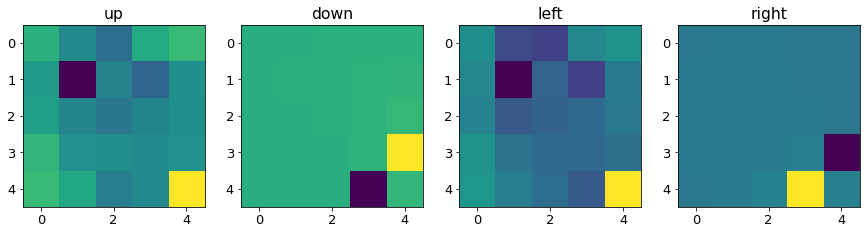

In [22]:
fig, ax = plt.subplots(1,4, figsize=(15,15))

ax[0].imshow(np.reshape(mac.tA[:,0], [grid_size, grid_size]))
ax[0].set_title('up')
ax[1].imshow(np.reshape(mac.tA[:,1], [grid_size, grid_size]))
ax[1].set_title('down')
ax[2].imshow(np.reshape(mac.tA[:,2], [grid_size, grid_size]))
ax[2].set_title('left')
ax[3].imshow(np.reshape(mac.tA[:,3], [grid_size, grid_size]))
ax[3].set_title('right')
plt.show()

# SR

In [77]:
n_episodes = 10000
n_steps = 70

In [89]:
node_list = list(env.G.nodes)
mSize = len(node_list)
n_actions = 4
gamma = 0.6
alpha = 0.01
beta = 0.7

sra = SuccessorAgent(mSize, n_actions, alpha, gamma, beta)
xp, err, sv = run_sim(env, sra, n_episodes, n_steps)

In [90]:
sra.get_V().max()

11.534174145185222

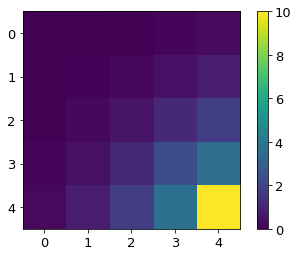

In [93]:
plt.imshow(sra.get_V(), vmin = 0, vmax = 10)
plt.colorbar()

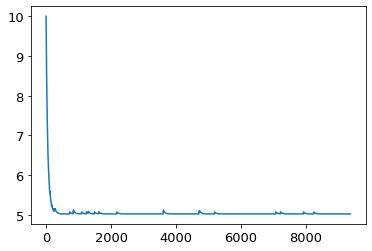

In [92]:
plt.plot(err)

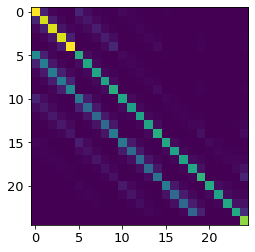

In [87]:
plt.imshow(sra.M[0,:,:])

Text(0.5, 1.0, 'right')

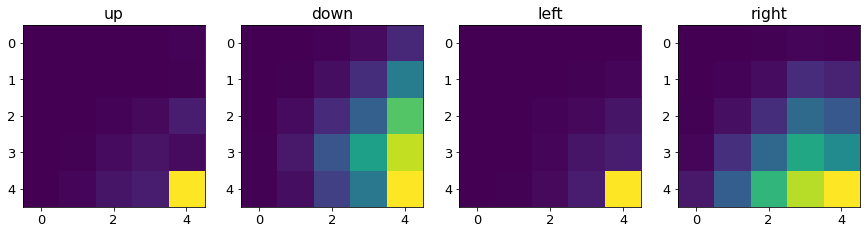

In [75]:
fig, ax = plt.subplots(1,4, figsize=(15,15))
ax[0].imshow(np.reshape(sra.tA[:,0], [grid_size, grid_size]))
ax[0].set_title('up')
ax[1].imshow(np.reshape(sra.tA[:,1], [grid_size, grid_size]))
ax[1].set_title('down')
ax[2].imshow(np.reshape(sra.tA[:,2], [grid_size, grid_size]))
ax[2].set_title('left')
ax[3].imshow(np.reshape(sra.tA[:,3], [grid_size, grid_size]))
ax[3].set_title('right')

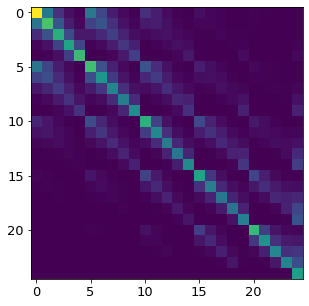

In [76]:
averaged_M = np.mean(sra.M, axis=0)
plt.figure(figsize = (5,5))
plt.imshow(averaged_M)

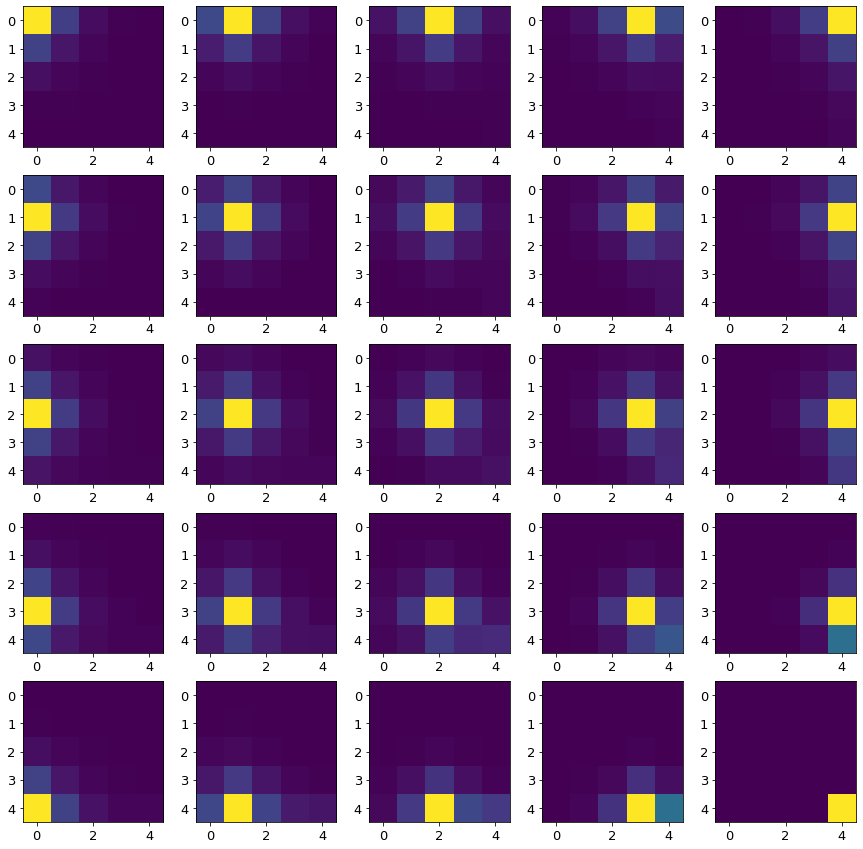

In [41]:
averaged_M = np.reshape(averaged_M, [sra.state_size, grid_size, grid_size])

cmap = plt.cm.viridis
cmap.set_bad(color='white')

plt.figure(1, figsize=(grid_size*3, grid_size*3))
for i in range(sra.state_size):
    ax = plt.subplot(grid_size, grid_size, i + 1)
    ax.imshow(averaged_M[i,:,:], cmap=cmap)

# All agents combined

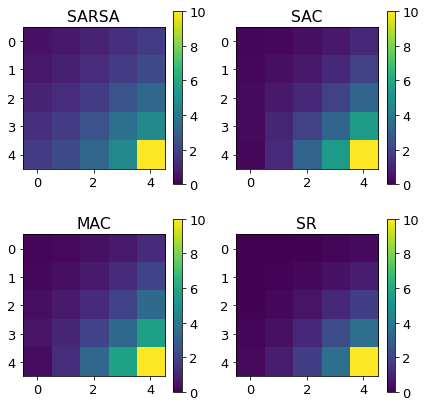

In [97]:
fig, ax = plt.subplots(2,2, figsize=(7,7))

im1 = ax[0,0].imshow(sar.get_V(), vmin = 0, vmax = 10)
ax[0,0].set_title('SARSA')
plt.colorbar(im1, ax=ax[0, 0])

im2 = ax[0,1].imshow(sac.get_V(), vmin = 0, vmax = 10)
ax[0,1].set_title('SAC')
plt.colorbar(im2, ax=ax[0, 1])

im3 = ax[1,0].imshow(mac.get_V(), vmin = 0, vmax = 10)
ax[1,0].set_title('MAC')
plt.colorbar(im3, ax=ax[1, 0])

im4 = ax[1,1].imshow(sra.get_V(), vmin = 0, vmax = 10)
ax[1,1].set_title('SR')
plt.colorbar(im4, ax=ax[1, 1])

plt.show()

# some questions
* why does SARSA and SR converge to 8 and Actor-Critic to 10?
    * there was a terminal flag condition that was blocking the last state reward
    * however now it's converging past 10..
* run through 4-room